# Initial Imports

In [18]:
import numpy as np
import time
import os
import matplotlib.pyplot as plt

from multirtd.planners.RTD_planner import RTD_Planner
from multirtd.reachability.zonotope import Zonotope
import multirtd.params as params
from multirtd.reachability import compute_FRS
from multirtd.dynamics.LPM import LPM

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# One Planner

In [43]:
# Initialize planner
p_0 = np.array([[-5], [0]])
LPM_file = os.path.join(os.getcwd(),'..', 'models', 'quadrotor_linear_planning_model.mat')
planner = RTD_Planner(LPM_file, p_0)

In [44]:
# Set planner goal and obstacles
planner.p_goal = np.array([[5], [0]])
# (center, radius) tuples
planner.obstacles = [Zonotope(np.array([2.5, 1.5])[:,None], 0.5*np.array([[1, 1], [1, -1]])),
                     Zonotope(np.array([0, -1.5])[:,None], 0.5*np.array([[1, 1], [1, -1]])),
                     Zonotope(np.array([-2.5, 1.5])[:,None], 0.5*np.array([[1, 1], [1, -1]]))]

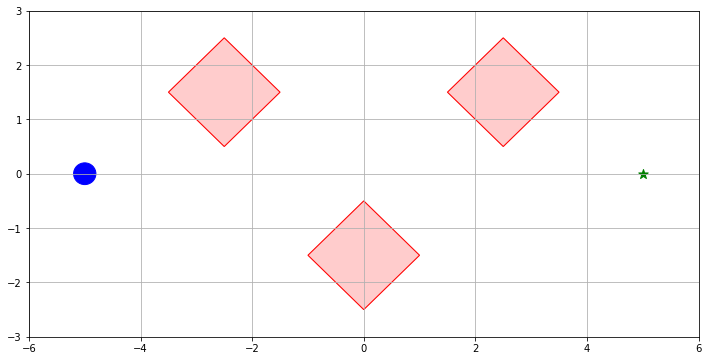

In [45]:
# Visualize setup
fig, ax = plt.subplots(figsize=(12,6))
ax.set_xlim((-6, 6))
ax.set_ylim((-3, 3))
ax.grid()

#ax.scatter(p_0[0], p_0[1], s=50, marker='^', color='b')
ax.add_patch(plt.Circle(tuple(p_0), params.R_BOT, color='b'))
ax.scatter(planner.p_goal[0], planner.p_goal[1], s=100, marker='*', color='g')

for obs in planner.obstacles:
    obs.plot(ax, color='r')

plt.show()

In [46]:
# "Controller" loop frequency 
# Determined by trajectory discretization
# Currently the controller just pops off setpoints from the planner trajectories to save for plotting
controller_hz = 10  # 0.1 s

# Planner loop frequency
# Determines time between replans
planner_hz = 2  # 0.5 s

t_sim = 0  # counter for simulation time
trajectory = None
traj_idx = 0
done = False

# Initialize state
p = p_0
v = np.zeros((2,1))
a = np.zeros((2,1))
# State history
P = []
planning_times = []
FRS = []

while not done:

    # Planner
    if t_sim % int(controller_hz/planner_hz) == 0:
        # Replan
        print("Replanning: t_sim = ", t_sim)
        start_t = time.time()
        trajectory = planner.replan((p,v,a))
        planning_times.append(time.time() - start_t)
        traj_idx = 0

    # Controller
    # Pop off next setpoint
    p = trajectory[0][:,traj_idx][:,None]
    v = trajectory[1][:,traj_idx][:,None]
    a = trajectory[2][:,traj_idx][:,None]
    P.append(p)
    traj_idx += 1

    FRS.append(trajectory[3][traj_idx])

    if np.linalg.norm(p - planner.p_goal) < params.R_GOAL_REACHED:
        print("Goal reached")
        done = True

    t_sim += 1

P = np.hstack(P)
print("Average planning time: ", np.mean(planning_times), " seconds")

Replanning: t_sim =  0
Replanning: t_sim =  5
Replanning: t_sim =  10
Replanning: t_sim =  15
Replanning: t_sim =  20
Replanning: t_sim =  25
Replanning: t_sim =  30
Replanning: t_sim =  35
Replanning: t_sim =  40
Replanning: t_sim =  45
Replanning: t_sim =  50
Replanning: t_sim =  55
Replanning: t_sim =  60
Replanning: t_sim =  65
Replanning: t_sim =  70
Replanning: t_sim =  75
Replanning: t_sim =  80
Replanning: t_sim =  85
Replanning: t_sim =  90
Replanning: t_sim =  95
Replanning: t_sim =  100
Replanning: t_sim =  105
Replanning: t_sim =  110
Goal reached
Average planning time:  0.047349349312160324  seconds


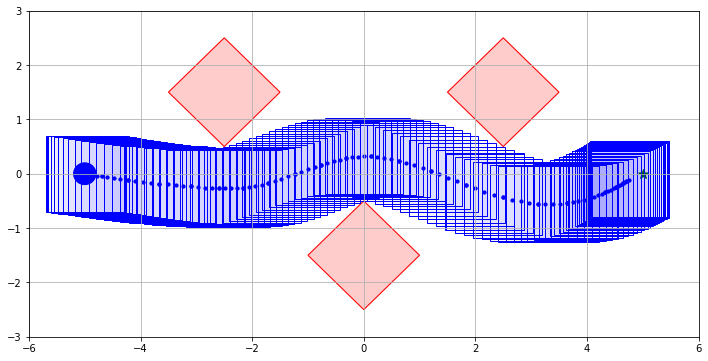

In [47]:
# Visualize setup
fig, ax = plt.subplots(figsize=(12,6))
ax.set_xlim((-6, 6))
ax.set_ylim((-3, 3))
ax.grid()

ax.add_patch(plt.Circle(tuple(p_0), params.R_BOT, color='b'))
ax.scatter(planner.p_goal[0], planner.p_goal[1], s=100, marker='*', color='g')

for obs in planner.obstacles:
    obs.plot(ax, color='r')

# Plot trajectory
ax.scatter(P[0,:], P[1,:], s=10, marker='o', color='b')

for z in FRS:
    z.view([0,1]).plot(ax, alpha=0.01)

plt.show()

In [49]:
P.shape

(2, 115)

# Swarm

In [2]:
# Initialize planners
n = 4
p_0s = np.array([[1.0,1.0,-1.0,-1.0],[1.0,-1.0,1.0,-1.0]]) #(np.random.rand(2,n)+1)*np.array([[1,1,-1,-1],[1,-1,1,-1]])
LPM_file = os.path.join(os.getcwd(),'..', 'models', 'quadrotor_linear_planning_model.mat')
planners = []
for i in range(n):
    planners.append(RTD_Planner(LPM_file, p_0s[:,i]))

In [3]:
# Set planner goal and obstacles
# (center, radius) tuples
static = [Zonotope(np.array([3.5, 2.5])[:,None], 0.5*np.array([[1, 1], [1, -1]])),
          Zonotope(np.array([0, -3.5])[:,None], 0.5*np.array([[1, 1], [1, -1]])),
          Zonotope(np.array([-3.5, 2.5])[:,None], 0.5*np.array([[1, 1], [1, -1]]))]
goals = np.array([[-1,-1,1,1],[-1,1,-1,1]])
for i in range(n):
    planners[i].p_goal = np.reshape(goals[:,i]*5,(2,1))
    #temp = np.random.rand(2,1)*4 - 2 # point within -2 to 2, -2 to 2 box
    #planners[i].p_goal = temp+4*temp/(temp**2)**.5 # if negative, subtract 4, if positive, add 4
    planners[i].obstacles = static

In [4]:
# "Controller" loop frequency 
# Determined by trajectory discretization
# Currently the controller just pops off setpoints from the planner trajectories to save for plotting
controller_hz = 10  # 0.1 s

# Planner loop frequency
# Determines time between replans
planner_hz = 2  # 0.5 s

t_sim = 0  # counter for simulation time
trajectories = [None]*p_0s.shape[1]
traj_idx = 0
done = False

# Initialize state
ps = p_0s.copy()
vs = np.zeros((2,n))
a_s = np.zeros((2,n))
# State history
Ps = [[],[],[],[]]
planning_times = []
FRSs = [[],[],[],[]]

while not done:

    # Planner
    if t_sim % int(controller_hz/planner_hz) == 0:
        # Replan
        print("Replanning: t_sim = ", t_sim)
        start_t = time.time()
        for i in range(n):
            trajectories[i] = planners[i].replan((np.reshape(ps[:,i],(2,1)),
                                                  np.reshape(vs[:,i],(2,1)),
                                                  np.reshape(a_s[:,i],(2,1))))
        planning_times.append(time.time() - start_t)
        traj_idx = 0

    # Controller
    # Pop off next setpoint
    for i in range(n):
        if trajectories[i] != None:
            ps[0,i] = trajectories[i][0][:,traj_idx][:,None][0,0]
            ps[1,i] = trajectories[i][0][:,traj_idx][:,None][1,0]
            vs[0,i] = trajectories[i][1][:,traj_idx][:,None][0,0]
            vs[1,i] = trajectories[i][1][:,traj_idx][:,None][1,0]
            a_s[0,i] = trajectories[i][2][:,traj_idx][:,None][0,0]
            a_s[1,i] = trajectories[i][2][:,traj_idx][:,None][1,0]
        Ps[i].append(np.reshape(ps[:,i],(2,1)).copy())
    traj_idx += 1

    for i in range(n):
        if trajectories[i] != None:
            FRSs[i].append(trajectories[i][3][traj_idx:traj_idx+2])
        else:
            FRSs[i].append(FRSs[i][-1])
            
    if t_sim % int(controller_hz/planner_hz) == 0:
        for i in range(n):
            others = FRSs.copy()
            del(others[i])
            others = np.array(others)[:,-1]
            others_view = []
            for agent in others:
                others_view.append(agent[0].view([0,1]))
                others_view.append(agent[1].view([0,1]))
            planners[i].obstacles = static.copy() + list(others_view)

    dists = np.zeros(4)
    for i in range(n):
        dists[i] = np.linalg.norm(np.reshape(ps[:,i],(2,1)) - planners[i].p_goal)
    goal_check = np.where(dists < params.R_GOAL_REACHED,1,0)
    
    if np.sum(goal_check)==n:
        print("Goal reached")
        done = True

    t_sim += 1
    if t_sim > 199:
        break

Ps = np.hstack(Ps)[:,:,0]
print("Average planning time: ", np.mean(planning_times), " seconds")

Replanning: t_sim =  0
Replanning: t_sim =  5
Replanning: t_sim =  10
Replanning: t_sim =  15
Replanning: t_sim =  20
No solution found.
No solution found.
No solution found.
No solution found.
Replanning: t_sim =  25
No solution found.
No solution found.
No solution found.
No solution found.
Replanning: t_sim =  30
No solution found.
No solution found.
No solution found.
No solution found.
Replanning: t_sim =  35
No solution found.
No solution found.
No solution found.
No solution found.
Replanning: t_sim =  40
No solution found.
No solution found.
No solution found.
No solution found.
Replanning: t_sim =  45
No solution found.
No solution found.
No solution found.
No solution found.
Replanning: t_sim =  50
No solution found.
No solution found.
No solution found.
No solution found.
Replanning: t_sim =  55
No solution found.
No solution found.
No solution found.
No solution found.
Replanning: t_sim =  60
No solution found.
No solution found.
No solution found.
No solution found.
Replan

In [338]:
Ps[2:2+2]

[[array([[-1.],
         [ 1.]])],
 [array([[-1.],
         [-1.]])]]

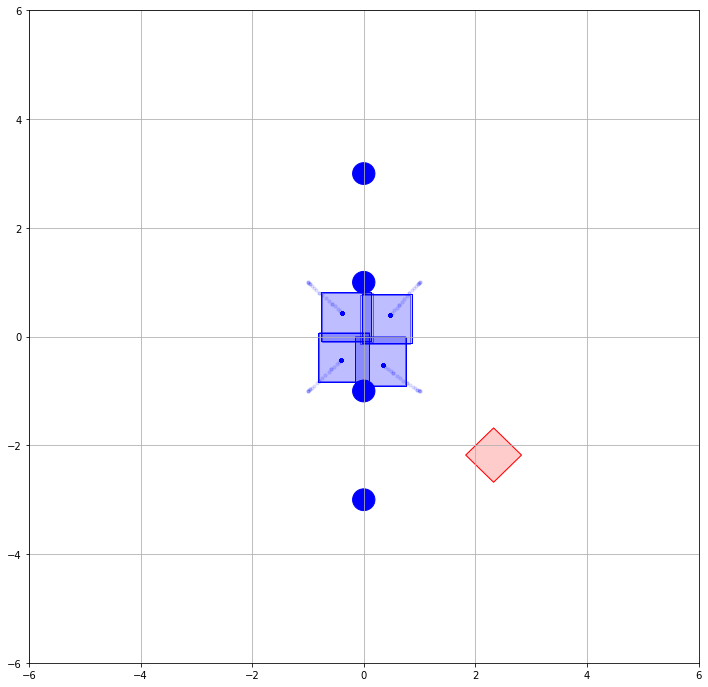

In [8]:
# Visualize setup
fig, ax = plt.subplots(figsize=(12,12))
ax.set_xlim((-6, 6))
ax.set_ylim((-6, 6))
ax.grid()

for i in range(n):
    ax.add_patch(plt.Circle(tuple(p_0s[:,i]), params.R_BOT, color='b'))
    ax.scatter(planners[i].p_goal[0], planners[i].p_goal[1], s=100, marker='*', color='g')
    ax.add_patch(plt.Circle(tuple(planners[i].p_goal), params.R_GOAL_REACHED, color='g',alpha=.1))

for obs in static:
    obs.plot(ax, color='r')

pt = 20
# Plot trajectory
for i in range(n):
    ax.scatter(Ps[:,0+i*2], Ps[:,1+i*2], s=10, marker='o', color='b',alpha=.1)

for i in range(n):
    #g = 0.0
    #b = 1.0
    last = None
    for z in FRSs[i][-pt:]:
        if z != None:
            z[0].view([0,1]).plot(ax, alpha=0.01, line_alpha=.1) #color=(0,g,b),
            last = z
        elif last != None:
            last[0].view([0,1]).plot(ax, alpha=0.01, line_alpha=.1)
    last[0].view([0,1]).plot(ax, alpha=0.01, line_alpha=.5)
    last[1].view([0,1]).plot(ax, alpha=0.01, line_alpha=.5)
        #g += 1/20
        #b -= 1/20

plt.show()

In [8]:
np.tile(np.array([-2,2]),(1,2))[0]

array([-2,  2, -2,  2])

AttributeError: 'list' object has no attribute 'view'

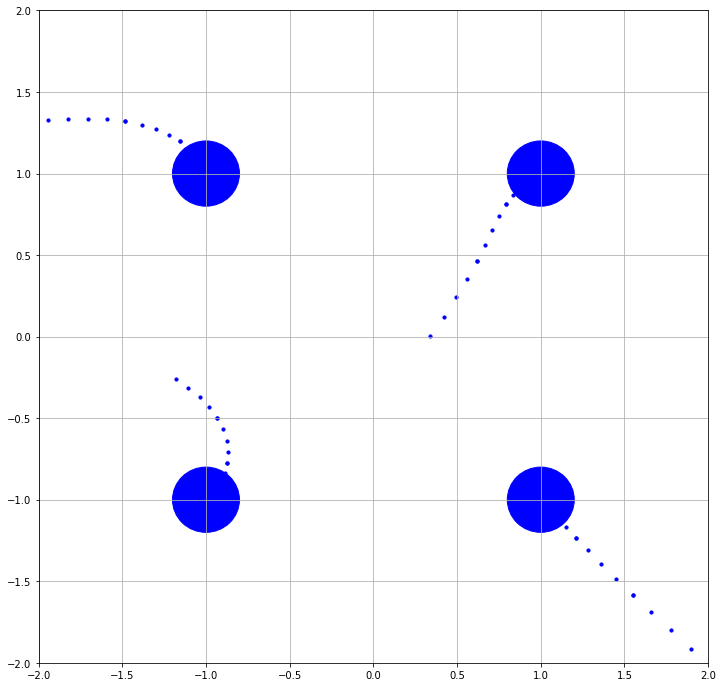

In [9]:
# Visualize setup
fig, ax = plt.subplots(figsize=(12,12))
ax.set_xlim((-2, 2))
ax.set_ylim((-2, 2))
ax.grid()

for i in range(n):
    ax.add_patch(plt.Circle(tuple(p_0s[:,i]), params.R_BOT, color='b'))
    ax.scatter(planners[i].p_goal[0], planners[i].p_goal[1], s=100, marker='*', color='g')

for obs in static:
    obs.plot(ax, color='r')

# Plot trajectory
for i in range(n):
    ax.scatter(Ps[:20,0+i*2], Ps[:20,1+i*2], s=10, marker='o', color='b')

for i in range(n):
    #for z in FRSs[i][:20]:
        #z.view([0,1]).plot(ax, alpha=0.01, line_alpha=.1)
    FRSs[i][0].view([0,1]).plot(ax, alpha=0.1, line_alpha=.5)

plt.show()

# Going on a trip

In [19]:
# Initialize planners
n = 4
p_0s = np.array([[0.0,0.0,0.0,0.0],[3.0,1.0,-1.0,-3.0]])
LPM_file = os.path.join(os.getcwd(),'..', 'models', 'quadrotor_linear_planning_model.mat')
planners = []
for i in range(n):
    planners.append(RTD_Planner(LPM_file, p_0s[:,i]))

In [20]:
# Set planner goal and obstacles
l = 25
w = 3
n_obs = 2
#locs = np.random.rand(2,n_obs)*np.array([[l-4],[2*w]]) + np.array([[2],[-w]])
static = []
for i in range(n_obs):
    static.append(Zonotope(locs[:,i][:,None], 0.25*np.array([[1, 1], [1, -1]])))
goals = np.array([[l,l,l,l],[-3,-1,1,3]])
for i in range(n):
    planners[i].p_goal = np.reshape(goals[:,i],(2,1))
    planners[i].obstacles = static

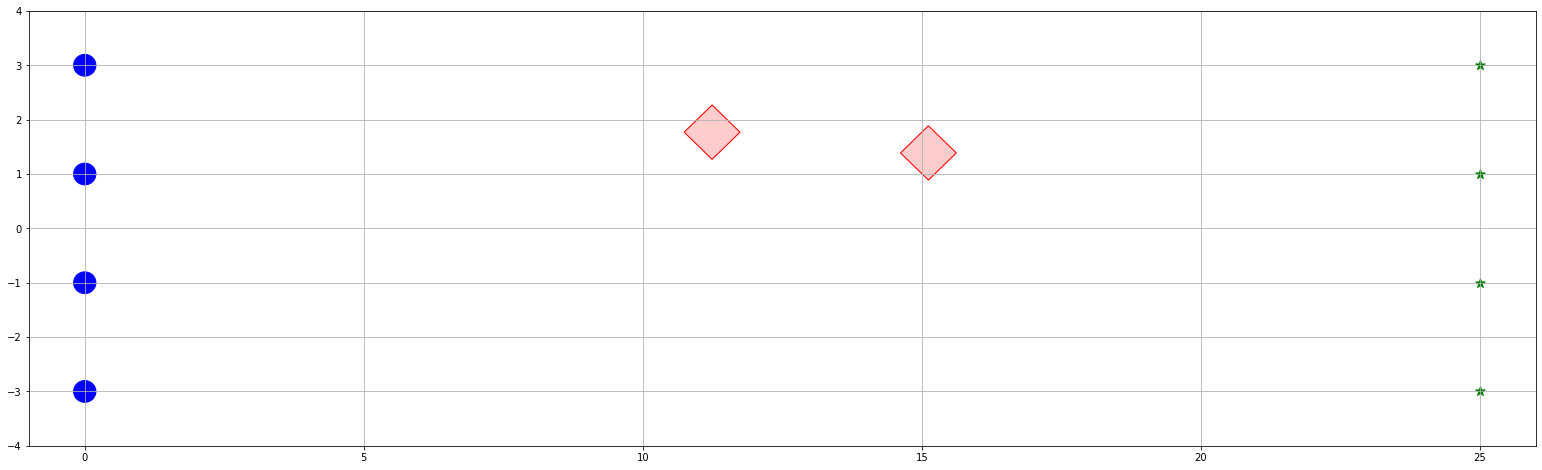

In [21]:
# Visualize setup
fig, ax = plt.subplots(figsize=(l+2,2*(w+1)))
ax.set_xlim((-1, l+1))
ax.set_ylim((-w-1, w+1))
ax.grid()

for i in range(n):
    ax.add_patch(plt.Circle(tuple(p_0s[:,i]), params.R_BOT, color='b'))
    ax.scatter(planners[i].p_goal[0], planners[i].p_goal[1], s=100, marker='*', color='g')

for obs in static:
    obs.plot(ax, color='r')

In [23]:
# "Controller" loop frequency 
# Determined by trajectory discretization
# Currently the controller just pops off setpoints from the planner trajectories to save for plotting
controller_hz = 10  # 0.1 s

# Planner loop frequency
# Determines time between replans
planner_hz = 2  # 0.5 s

t_sim = 0  # counter for simulation time
trajectories = [None]*p_0s.shape[1]
traj_idx = 0
done = False

# Initialize state
ps = p_0s.copy()
vs = np.zeros((2,n))
a_s = np.zeros((2,n))
# State history
Ps = [[],[],[],[]]
planning_times = []
FRSs = [[],[],[],[]]
plotted_FRS = [[],[],[],[]]
dropped = []
lpm = LPM(LPM_file)
last_state = [np.reshape(ps[:,0],(2,1)),np.reshape(vs[:,0],(2,1)),np.reshape(a_s[:,0],(2,1))]
t = 0

while not done:

    # Planner
    if t_sim % int(controller_hz/planner_hz) == 0:
        # Replan
        print("Replanning: t_sim = ", t_sim)
        start_t = time.time()
        for i in range(n):
            trajectories[i] = planners[i].replan((np.reshape(ps[:,i],(2,1)),
                                                  np.reshape(vs[:,i],(2,1)),
                                                  np.reshape(a_s[:,i],(2,1))))
        planning_times.append(time.time() - start_t)
        traj_idx = 0

    # Controller
    # Pop off next setpoint
    for i in range(n):
        if trajectories[i] != None:
            ps[0,i] = trajectories[i][0][:,traj_idx][:,None][0,0]
            ps[1,i] = trajectories[i][0][:,traj_idx][:,None][1,0]
            vs[0,i] = trajectories[i][1][:,traj_idx][:,None][0,0]
            vs[1,i] = trajectories[i][1][:,traj_idx][:,None][1,0]
            a_s[0,i] = trajectories[i][2][:,traj_idx][:,None][0,0]
            a_s[1,i] = trajectories[i][2][:,traj_idx][:,None][1,0]
        Ps[i].append(np.reshape(ps[:,i],(2,1)).copy())

    for i in range(n):
        if trajectories[i] != None:
            FRSs[i].append(trajectories[i][3])
        else:
            FRSs[i].append(FRSs[i][-1])
    
    if t_sim % int(controller_hz/planner_hz*3) == 0:
        p_d = 0
        drop = np.random.choice([True,False],p=[p_d,1-p_d])
        if drop:
            drop_frs = compute_FRS(lpm, last_state[0], last_state[1], last_state[2])[1:]
            t = 0

    all_ag = FRSs.copy()
    # Randomly drop communications from agent 0
    dropped.append(drop)
    if drop:
        # Compute the FRS based on the last known state, instead of using the more specific slice
        all_ag[0][-1] = drop_frs # that first one is useless for some reason
        #print(all_ag[0][-1][traj_idx].c[0])
        plotted_FRS[0].append(all_ag[0][-1][t]) # Iterate through FRS generated at drop point
    else:
        last_state = [np.reshape(ps[:,0],(2,1)),np.reshape(vs[:,0],(2,1)),np.reshape(a_s[:,0],(2,1))]
        plotted_FRS[0].append(all_ag[0][-1][traj_idx])
    for i in range(1,n):
        plotted_FRS[i].append(all_ag[i][-1][traj_idx])
    if t_sim % int(controller_hz/planner_hz) == 0:
        for i in range(n):
            #print(i,len(all_ag[i]),traj_idx)
            others = all_ag.copy()
            del(others[i])
            #print(np.array(others).shape)
            others = np.array(others)[:,-1]
            planners[i].agents = others
            #others_view = []
            #for agent in others:
            #    others_view.append(agent[0].view([0,1]))
            #    others_view.append(agent[1].view([0,1]))
            #    others_view.append(agent[2].view([0,1]))
            #planners[i].obstacles = static.copy() + list(others_view)
            

    dists = np.zeros(4)
    for i in range(n):
        dists[i] = np.linalg.norm(np.reshape(ps[:,i],(2,1)) - planners[i].p_goal)
    goal_check = np.where(dists < params.R_GOAL_REACHED,1,0)
    
    if np.sum(goal_check)==n:
        print("Goal reached")
        done = True

    traj_idx += 1
    t += 1
    t_sim += 1
    stuck = (trajectories[0]==None) and (trajectories[1]==None) and (trajectories[2]==None) and (trajectories[3]==None)
    if t_sim > 299 or stuck:
        break

Ps = np.hstack(Ps)[:,:,0]
print("Average planning time: ", np.mean(planning_times), " seconds")

Replanning: t_sim =  0
Replanning: t_sim =  5
Replanning: t_sim =  10
Replanning: t_sim =  15
Replanning: t_sim =  20
Replanning: t_sim =  25
Replanning: t_sim =  30
Replanning: t_sim =  35
Replanning: t_sim =  40
Replanning: t_sim =  45
Replanning: t_sim =  50
Replanning: t_sim =  55
Replanning: t_sim =  60
Replanning: t_sim =  65
Replanning: t_sim =  70
Replanning: t_sim =  75
Replanning: t_sim =  80
Replanning: t_sim =  85
Replanning: t_sim =  90
Replanning: t_sim =  95
Replanning: t_sim =  100
Replanning: t_sim =  105
Replanning: t_sim =  110
Replanning: t_sim =  115
Replanning: t_sim =  120
Replanning: t_sim =  125
Replanning: t_sim =  130
Replanning: t_sim =  135
Replanning: t_sim =  140
Replanning: t_sim =  145
Replanning: t_sim =  150
No solution found.
Replanning: t_sim =  155
No solution found.
Replanning: t_sim =  160
Replanning: t_sim =  165
Replanning: t_sim =  170
Replanning: t_sim =  175
Replanning: t_sim =  180
Replanning: t_sim =  185
Replanning: t_sim =  190
Replannin

In [41]:
np.where(np.array(dropped)==True)

(array([ 15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
         71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
         97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
        110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 165, 166, 167,
        168, 169, 170, 171, 172, 173, 174, 175, 176, 177], dtype=int64),)

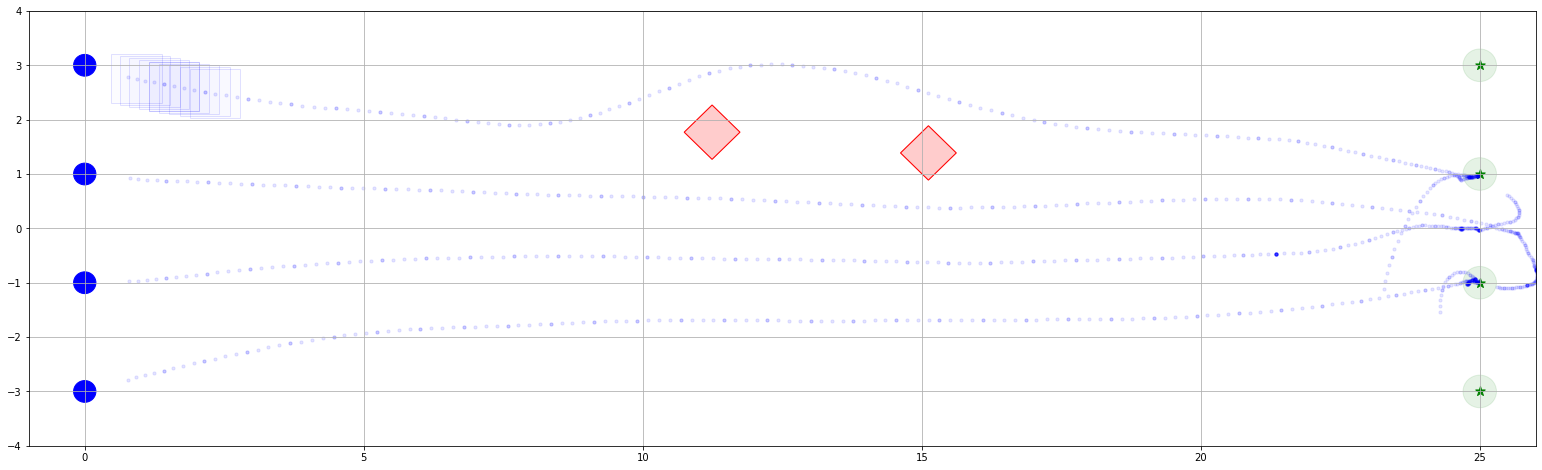

In [25]:
# Visualize setup
fig, ax = plt.subplots(figsize=(l+2,2*(w+1)))
ax.set_xlim((-1, l+1))
ax.set_ylim((-w-1, w+1))
ax.grid()

for i in range(n):
    ax.add_patch(plt.Circle(tuple(p_0s[:,i]), params.R_BOT, color='b'))
    ax.scatter(planners[i].p_goal[0], planners[i].p_goal[1], s=100, marker='*', color='g')
    ax.add_patch(plt.Circle(tuple(planners[i].p_goal), params.R_GOAL_REACHED, color='g',alpha=.1))

for obs in static:
    obs.plot(ax, color='r')

pt = 25
# Plot trajectory
for i in range(n):
    ax.scatter(Ps[15:,i*2], Ps[15:,1+i*2], s=10, marker='o', color='b',alpha=.1)

for i in range(n):
    #last = None
    ind = 0
    for z in plotted_FRS[i][15:pt]: #FRSs[i][:pt]:
        if z != None:
            col = 'b'
            alp = .01
            lalp = .1
            if dropped[ind+15] == True:
                if i==0:
                    col = 'r'
                    alp = .1
                    lalp = .2
            if i ==0:
                z.view([0,1]).plot(ax, color=col, alpha=alp, line_alpha=lalp) #color=(0,g,b),
        ind += 1
            #last = z
        #elif last != None:
            #last[0].view([0,1]).plot(ax, alpha=0.01, line_alpha=.1)
    #last[0].view([0,1]).plot(ax, alpha=0.01, line_alpha=.5)
    #last[1].view([0,1]).plot(ax, alpha=0.01, line_alpha=.5)

plt.show()

# Let's make a gif :)

In [26]:
import imageio

In [27]:
def gen_frame(j):
    # Visualize setup
    fig, ax = plt.subplots(figsize=(l+2,2*(w+1)))
    ax.set_xlim((-1, l+1))
    ax.set_ylim((-w-1, w+1))
    ax.grid()

    for i in range(n):
        ax.add_patch(plt.Circle(tuple(p_0s[:,i]), params.R_BOT, color='b'))
        ax.scatter(planners[i].p_goal[0], planners[i].p_goal[1], s=100, marker='*', color='g')
        ax.add_patch(plt.Circle(tuple(planners[i].p_goal), params.R_GOAL_REACHED, color='g',alpha=.1))

    for obs in static:
        obs.plot(ax, color='r')

    pt = 10
    # Plot trajectory
    for i in range(n):
        ax.scatter(Ps[:j,i*2], Ps[:j,1+i*2], s=10, marker='o', color='b',alpha=.1)

    if j >= pt:
        start = j-pt
    else:
        start = 0
    for i in range(n):
        #last = None
        ind = start
        for z in plotted_FRS[i][start:j]:
            #print(ind,dropped[ind])
            if dropped[ind] and i == 0:
                col = 'r'
            else:
                #print("got here")
                col = 'b'
            if z != None:
                z.view([0,1]).plot(ax, color=col, alpha=0.01, line_alpha=.1) #color=(0,g,b),
                last = z
            ind += 1
            #elif last != None:
            #    last[0].view([0,1]).plot(ax, alpha=0.01, line_alpha=.1)
        #if last != None:
        #    last.view([0,1]).plot(ax, alpha=0.01, line_alpha=.5)
        #    last.view([0,1]).plot(ax, color = 'g', alpha=0.01, line_alpha=.5)

    # Used to return the plot as an image rray
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close("all")
    print(j)
    return image

kwargs_write = {'fps':1.0, 'quantizer':'nq'}
#final version should be 90x160px
imageio.mimsave('./zoom.gif', [gen_frame(j) for j in range(len(Ps[:,0]))], fps=12) #len(Ps[:,0])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [80]:
x = [1,2,3,4]
x[2-2:2]

[1, 2]

In [371]:
dropped[]

False

In [17]:
list1 = [0,1,2,3]
list2 = [4,5,6,7]
list1+list2

[0, 1, 2, 3, 4, 5, 6, 7]